# AML HW-4 

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings

## Read train data

In [6]:
train = pd.read_csv('rscience-popular-comment-removal/reddit_200k_train.csv',
                    encoding='iso-8859-1')
train = train[['body','REMOVED']]
train = train.sample(n=20000)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 93004 to 69344
Data columns (total 2 columns):
body       20000 non-null object
REMOVED    20000 non-null bool
dtypes: bool(1), object(1)
memory usage: 332.0+ KB


## Read Test Data

In [7]:
test = pd.read_csv('rscience-popular-comment-removal/reddit_200k_test.csv',
                   encoding='iso-8859-1')
test = test[['body','REMOVED']]
test = test.sample(n=4000)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 36500 to 13330
Data columns (total 2 columns):
body       4000 non-null object
REMOVED    4000 non-null bool
dtypes: bool(1), object(1)
memory usage: 66.4+ KB


## Visualize the imbalance

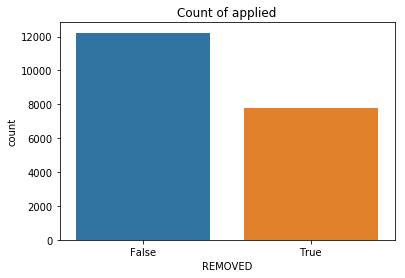

In [66]:
import seaborn as sns
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='REMOVED', data=train)
plt.title("Count of applied")
plt.show()

From the above plot, we can observe that the dataset doesn't have a remarkabke imbalance. It is pretty fair. For this homework, we choose roc_auc as our scoring parameter. It is a robust measure classification performance. Also, we do not split the train data into test/train, we train the models on the whole train data and test on the test data provided.

The below code snippet collects a list of stop words from the nltk API.

In [9]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Q1.1

As a baseline model, we present countvectorizer with default parameters and fit a logistic regression model on the data.

## Count vectorizer

In [69]:
from sklearn.linear_model import LogisticRegression
with warnings.catch_warnings():
    vect = CountVectorizer()
    X_train = vect.fit_transform(train['body'])
    lr = LogisticRegression().fit(X_train, train['REMOVED'])
    y_pred = lr.predict(vect.transform(test['body']))

/Users/alex/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [70]:
from sklearn.metrics import roc_auc_score
print("ROC AUC score on test data for the baseline model:")
roc_auc_score(test['REMOVED'].values.ravel(),y_pred)

0.6534125674057227

The above score is the baseline roc_auc.

<BarContainer object of 10 artists>

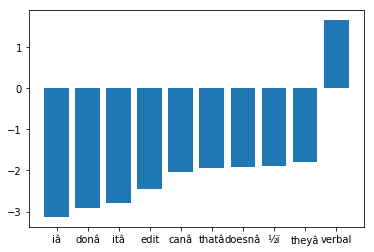

In [72]:
# lr.coef_.tolist()[0]
import matplotlib.pyplot as plt
df = pd.DataFrame({'features':vect.get_feature_names(),'coeffs':lr.coef_.tolist()[0]})
df = df.reindex(df.coeffs.abs().sort_values(ascending = False).index)
plt.bar(df.iloc[:10,0],df.iloc[:10,1])

Removing punctuations/ stop words still hurt the model performance. This can be inferred as such words being a key differentiator between bad and good comments.

## Q1.2

## TFIDF Vectorization (default parameters)

In [5]:
data_x = train['body']
data_y = train['REMOVED']

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    param_lr = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100] }
    gs_lr = GridSearchCV(estimator=make_pipeline(TfidfVectorizer(),
                                                 LogisticRegression()),
                         param_grid=param_lr,scoring="roc_auc")
    gs_lr.fit(data_x,data_y)
    print("TFIDF vectorizer with default parameters with GridSearchCV on \
        regularization parameter gives the best parameter and roc auc validation score:")
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)

TFIDF vectorizer with default parameters with GridSearchCV on regularization parameter gives the best parameter and roc auc validation score:
{'logisticregression__C': 1}
0.7339112649110733


In [9]:
from sklearn.metrics import roc_auc_score
y_pred = gs_lr.best_estimator_.predict(test['body'])
print("The test score for the above model is :")
roc_auc_score(test['REMOVED'], y_pred)

The test score for the above model is :


0.6368888956870992

## Count Vectorizer (bi-grams)

In [75]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    param_lr = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100] }
    gs_lr = GridSearchCV(estimator=make_pipeline(CountVectorizer(ngram_range=(1,2)),
                                                 LogisticRegression()),
                         param_grid=param_lr,scoring="roc_auc")
    gs_lr.fit(data_x,data_y)
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)

{'logisticregression__C': 0.1}
0.7286419756419035


As shown above is the count vectorizer with bi-grams included and GridSearchCV on regularization parameter gives the best parameter and roc auc validation score

In [76]:
y_pred = gs_lr.best_estimator_.predict(test['body'])
roc_auc_score(test['REMOVED'],y_pred)

0.668593654478653

As shown above is the test roc auc for the same model

## Count vectorization with Normalization and Grid Search on min_df and ngram_range

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_grid = {"logisticregression__C": [10, 1, 0.1],
                  "countvectorizer__ngram_range": [(2, 2), (2, 3)],
                  "countvectorizer__min_df": [1, 2, 3],
                 }
    grid = GridSearchCV(make_pipeline(CountVectorizer(), Normalizer(), 
                                      LogisticRegression(),
                                      memory="cache_folder"),
                        param_grid=param_grid, cv=3, scoring="roc_auc"
                       )
    grid.fit(text_train,y_train)
    print(grid.best_params_)
    print(grid.best_score_)

{'countvectorizer__min_df': 2, 'countvectorizer__ngram_range': (2, 2), 'logisticregression__C': 1}
0.6870029111181523


In [78]:
y_pred = gs_lr.best_estimator_.predict(test['body'])
roc_auc_score(test['REMOVED'],y_pred)

0.668593654478653

#### The above model is generalizes very well on different datasets. Most importantly, it doesn't overfit the training data. This is an important observation.

## Count Vectorization with character-grams that appear in at least 2 documents

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_grid = {"logisticregression__C": [10, 1, 0.1, 0.01]}
    grid = GridSearchCV(make_pipeline(CountVectorizer(analyzer="char_wb", 
                                                      ngram_range=(1, 2), 
                                                      min_df=2), 
                                      Normalizer(), LogisticRegression(),
                                      memory="cache_folder"),
                        param_grid=param_grid, cv=3, scoring="roc_auc"
                       )
    grid.fit(text_train,y_train)

In [80]:
print(grid.best_params_)
print(grid.best_score_)

{'logisticregression__C': 10}
0.7360287580783794


In [81]:
y_pred = gs_lr.best_estimator_.predict(test['body'])
roc_auc_score(test['REMOVED'],y_pred)

0.668593654478653

# Remove punctuation, numbers, stopwords, and one letter words

In [86]:
train_new = train.copy()

train_new['body'] = train_new['body'].str.replace(r'[^\w\s]+', '')
train_new['body'] = train_new['body'].str.replace(r'\d+', '')
train_new['body'] = train_new.apply(lambda x: ' '.join([item for \
    item in x['body'].split() if item not in stop and len(item) > 1]), axis=1)

test_new = test.copy()

test_new['body'] = test_new['body'].str.replace(r'[^\w\s]+', '')
test_new['body'] = test_new['body'].str.replace(r'\d+', '')
test_new['body'] = test_new.apply(lambda x: ' '.join([item for \
    item in x['body'].split() if item not in stop and len(item) > 1]), axis=1)

The following models fit the preprocessed data as above.

## TFIDF Vectorization + Grid Search (default parameters)

In [93]:
data_x = train_new['body']
data_y = train['REMOVED']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    param_lr = {'logisticregression__C': [0.1, 1, 10],
                'tfidfvectorizer__ngram_range': [(2,2), (2,3), (3,3)]}
    gs_lr = GridSearchCV(estimator=make_pipeline(TfidfVectorizer(min_df=2, 
                                                                 analyzer='char_wb'),
                                                 LogisticRegression()),
                         param_grid=param_lr,scoring="roc_auc")
    gs_lr.fit(data_x,data_y)
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)

{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (2, 3)}
0.7350216478366282


In [94]:
y_pred = gs_lr.best_estimator_.predict(test['body'])
roc_auc_score(test['REMOVED'], y_pred)

0.6600407364591309

## Tfidf Vectorization with l1 normalization for feature selection

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

data_x = train_new['body']
data_y = train['REMOVED']

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_grid = {"logisticregression__C": [10, 1, 0.1],
                  "tfidfvectorizer__ngram_range": [(2, 2), (2, 3), (3, 3)],
                 }
    grid = GridSearchCV(make_pipeline(TfidfVectorizer(min_df=2), 
                                      Normalizer(norm='l1'), LogisticRegression(),
                                      memory="cache_folder"),
                        param_grid=param_grid, cv=3, scoring="roc_auc"
                       )
    grid.fit(data_x, data_y)
    print(grid.best_params_)
    print(grid.best_score_)

{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (2, 2)}
0.6007656159548914


In [101]:
y_pred = grid.best_estimator_.predict(test['body'])
roc_auc_score(test['REMOVED'], y_pred)

0.5579356682125239

We are getting poor results after removing stop words and punctuations. That makes sense in a way that unwanted comments tend to contain many stop words or irrelavant punctuations.

## Parts Of Speech Tagging

In this method, we generate the part of speech for every word in the dataset and run a bag of words model on that transformed dataset with parts of speech as features.

In [105]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

df = []
for index,row in train['body'].iteritems():
    all_rows = []
    tokens = nltk.word_tokenize(row)
    pos = nltk.pos_tag(tokens)
    for tup in pos:
        all_rows.append(tup[1])
    df.append(all_rows)

df = np.array(df)
pos_train = []
for r in df:
    string = ' '.join(r)
    pos_train.append(string)
pos_train = np.array(pos_train)


[nltk_data] Downloading package punkt to /Users/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alex/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


(20000,)


In [106]:
df = []
for index,row in test['body'].iteritems():
    all_rows = []
    tokens = nltk.word_tokenize(row)
    pos = nltk.pos_tag(tokens)
    for tup in pos:
        all_rows.append(tup[1])
    df.append(all_rows)

df = np.array(df)
pos_test = []
for r in df:
    string = ' '.join(r)
    pos_test.append(string)
pos_test = np.array(pos_test)

(4000,)


In [114]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_grid = {"logisticregression__C": [0.0001,0.001,10, 1, 0.1,1000]}
    grid = GridSearchCV(make_pipeline(CountVectorizer(min_df=2), 
                                      LogisticRegression(),
                                      memory="cache_folder"),
                        param_grid=param_grid, cv=3, scoring="roc_auc"
                       )
    grid.fit(pos_train, train['REMOVED'])
    print(grid.best_params_)
    print(grid.best_score_)

{'logisticregression__C': 0.001}
0.6596571286812043


In [115]:
y_pred = grid.best_estimator_.predict(test['body'])
roc_auc_score(test['REMOVED'], y_pred)

0.5

#### POS tagging performs miserably bad and hence we discard this model

# 1.3 Deriving Other Features

In [138]:
import regex

def swear_words(row):
    sent = row['sent'].lower()
    matches = [r'fuck', r'shit', r'ass', r'bitch', r'dick']
    total = 0
    
    for pattern in matches:
        total += len(regex.findall(pattern, sent))
    
    return total
    
def strong_words(row):
    sent = row['sent'].lower()
    matches = [r'dumb', r'idiot', r'moron', r'stupid', r'suck', r'damn', r'hell']
    total = 0
    
    for pattern in matches:
        total += len(regex.findall(pattern, sent))
    
    return total

def html_tags(row):
    return len(regex.findall(r'</?\w+>', row['sent']))

def compute_wl(row):
    avgs_word = [len(x) for x in row['sent'].split()]
    return sum(avgs_word) / len(avgs_word) if len(avgs_word) != 0 else 0    

def feature_adder(data):
    data_df = pd.DataFrame({'index': data.index, 'sent': data.values})
    
    data_df['sent'] = data_df['sent'].str.replace(r'\d+', '')
    data_df['sent'] = data_df.apply(lambda x: ' '.join([item for \
        item in x['sent'].split() if item not in stop and len(item) > 1]), axis=1)
    
    data_df['length'] = data_df['sent'].apply(len)
    data_df['num_words'] = data_df['sent'].str.split().apply(len)
    data_df['avg_word_length'] = data_df.apply(lambda row: compute_wl(row), axis=1)
    data_df['word_length_ratio'] = data_df['num_words'] / data_df['length']
    data_df['num_caps'] = data_df.apply(lambda row: \
        sum(1 for c in row['sent'] if c.isupper()), axis=1)
    data_df['num_exclamations'] = data_df.apply(lambda row: \
        len(regex.findall(r'!', row['sent'])), axis=1)
    data_df['num_swear_words'] = data_df.apply(lambda row: swear_words(row), axis=1)
    data_df['num_strong_words'] = data_df.apply(lambda row: \
        len(regex.findall(r'</?\w+', row['sent'])), axis=1)
    
    return data_df

The new features added are:

length, number of words, average word length, word length ratio, number of capital letters, number of exclamations, number of swear words and number of strong words.

In [139]:
train_new_derived = feature_adder(train['body'])
test_new_derived = feature_adder(test['body'])

train_new_derived['REMOVED'] = train['REMOVED'].reset_index(drop=True)
test_new_derived['REMOVED'] = test['REMOVED'].reset_index(drop=True)

In [141]:
train_new_derived_x = train_new_derived.drop(columns=['index', 'sent', 'REMOVED'])
train_new_derived_y = train_new_derived['REMOVED']

In [142]:
test_new_derived_x = test_new_derived.drop(columns=['index', 'sent', 'REMOVED'])
test_new_derived_y = test_new_derived['REMOVED']

## With just new features (including polynomial features)

In [143]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_grid = {"C": [10, 1, 0.1]}
    
    grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, 
                        cv=3, scoring="roc_auc")
    grid.fit(train_new_derived_x, train_new_derived_y)
    print(grid.best_params_)
    print(grid.best_score_)

{'C': 0.1}
0.6648255850538843


In [144]:
y_pred = grid.best_estimator_.predict(test_new_derived_x)
roc_auc_score(test_new_derived_y, y_pred)

0.5433991053571894

## Map features to polynomial space

In [149]:
from sklearn.preprocessing import PolynomialFeatures

data_poly_x = PolynomialFeatures().fit(train_new_derived_x)
data_poly_x_train = data_poly_x.transform(train_new_derived_x)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_grid = {"C": [10, 1, 0.1]}
    
    grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, 
                        cv=3, scoring="roc_auc")
    grid.fit(data_poly_x_train, train_new_derived_y)
    print(grid.best_params_)
    print(grid.best_score_)

{'C': 1}
0.6700205293901936


In [151]:
data_poly_x_test = data_poly_x.transform(test_new_derived_x)
y_pred = grid.best_estimator_.predict(data_poly_x_test)
roc_auc_score(test_new_derived_y, y_pred)

0.5004751621121957

From the above, we conclude that the new features derived do not convey any information about the target variable. The models discussed prior to this are better than this model.

## With Lemmatization

We used nltk package to lemmatize words in the dataset and apply count vectorizer on it

In [162]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

wnl = WordNetLemmatizer()
df = []
for index,row in train['body'].iteritems():
    all_tokens = []
    tokens = nltk.word_tokenize(row)
    for token in tokens:
        all_tokens.append(wnl.lemmatize(token))
    df.append(all_tokens)

[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [163]:
mydf = []
for r in df:
    string = ' '.join(r)
    mydf.append(string)
mydf = np.array(mydf)

(20000,)


In [164]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    param_grid = {"logisticregression__C": [0.0001,0.001,10, 1, 0.1,1000]}
    grid = GridSearchCV(make_pipeline(CountVectorizer(min_df=2), 
                                      LogisticRegression(),
                                      memory="cache_folder"),
                        param_grid=param_grid, cv=3, scoring="roc_auc"
                       )
    grid.fit(mydf, train['REMOVED'])
    print("Cross validation best parameter and training score:")
    print(grid.best_params_)
    print(grid.best_score_)

{'logisticregression__C': 0.1}
0.7304707288480369


In [165]:
df = []
for index,row in test['body'].iteritems():
    all_tokens = []
    tokens = nltk.word_tokenize(row)
    for token in tokens:
        all_tokens.append(wnl.lemmatize(token))
    df.append(all_tokens)
    
lemm_test = []
for r in df:
    string = ' '.join(r)
    lemm_test.append(string)
lemm_test = np.array(lemm_test)

(4000,)


In [167]:
y_pred = grid.best_estimator_.predict(lemm_test)
print("Test score on lemmatized dataset:")
roc_auc_score(test['REMOVED'], y_pred)

0.6360010630566989

## Word2vec representation

In [1]:
import gensim
from gensim.models import Word2Vec

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',
                                                        binary=True)


In [2]:
def convert2vec(text):
    vec = []
    for index, doc in text.iteritems():
        mod_val = []
        for word in doc.split(' '):
            if word in stop or word.isdigit():
                continue
            try:
                mod_val.append(model[word])
            except:
                continue
        if not mod_val:
            vec.append([0]*300)
        else:
            vec.append(np.mean(np.array(mod_val), axis=0).tolist())
    return np.array(vec)

In [10]:
vec = convert2vec(train['body'])

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    param_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }
    gs_lr = GridSearchCV(estimator=LogisticRegression(),
                         param_grid=param_lr,scoring="roc_auc")
    gs_lr.fit(vec, train['REMOVED'])
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)


{'C': 0.1}
0.6993820442773924


In [13]:
from sklearn.metrics import roc_auc_score
y_pred = gs_lr.best_estimator_.predict(convert2vec(test['body']))
roc_auc_score(test['REMOVED'],y_pred)

0.5977853033322207

#### Word2vec is giving bad results possibly because it is a pre-trained model on a different corpus. It is creating a vector space where context of words is captured in the documents by which they are trained. So, this pretrained model may not hold good for our train/test data. This possibly explains the poor roc auc scores.

## Fast text representation

In [180]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
wv_from_text = KeyedVectors.load_word2vec_format(\
    datapath('/Users/alex/Desktop/AppliedML/homework-4-alk2225_av2845/wiki-news-300d-1M.vec'), binary=False)

In [184]:
def convert2vec(text):
    vec = []
    for index, doc in text.iteritems():
        mod_val = []
        for word in doc.split(' '):
            if word in stop or word.isdigit():
                continue
            try:
                mod_val.append(wv_from_text[word])
            except:
                continue
        if not mod_val:
            vec.append([0]*300)
        else:
            vec.append(np.mean(np.array(mod_val), axis=0).tolist())
    return np.array(vec)

In [ ]:
vec = convert2vec(train['body'])

In [185]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    param_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }
    gs_lr = GridSearchCV(estimator=LogisticRegression(),
                         param_grid=param_lr,scoring="roc_auc")
    gs_lr.fit(vec, train['REMOVED'])
    print(gs_lr.best_params_)
    print(gs_lr.best_score_)

{'C': 0.1}
0.6977924699550933


In [188]:
y_pred = gs_lr.best_estimator_.predict(convert2vec(test['body']))
roc_auc_score(test['REMOVED'],y_pred)

0.5002195385923033

The same explanation for word2vec holds for fasttext too!!

## Our best model

Our best model with all the above trials is as follows:
{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (2, 3)}
Cross validation score - 0.7350216478366282
Test score - 0.66

This is the most general model:
{'countvectorizer__min_df': 2, 'countvectorizer__ngram_range': (2, 2), 'logisticregression__C': 1}
cross validation score - 0.6870029111181523
Test score - 0.668593654478653
